In [5]:
import difflib
import nltk
import os
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from IPython.display import display, HTML
from nltk.tokenize import sent_tokenize

# Import the processors - update path as needed
from asabaal_utils.video_processing.transcript_processors import (
    TranscriptEnhancementPipeline,
    FillerWordsProcessor,
    RepetitionHandler,
    SentenceBoundaryDetector,
    SemanticUnitPreserver
)
from asabaal_utils.video_processing.transcript_visualizer import TranscriptEnhancementVisualizer, visualize_enhancement

# Set dark mode theme for all plots
plt.style.use('dark_background')

In [2]:
complex_transcript = """
hey everyone what's up
so I'm here today to tell you that I have
so I'm here today
not only to give you an update on the only permits
blessing um
I'm also here to tell you that in
I'm also here to tell you that I'm starting
another project
"""

## Visualizing the default pipeline steps ##

### Step: FillerWordsProcessor ###



### Step: RepetitionHandler ###



### Step: SentenceBoundaryDetector ###



### Step: SemanticUnitPreserver ###



## Testing different processor permutations ##

## Permutation 1: ['FillerWordsProcessor', 'RepetitionHandler', 'SentenceBoundaryDetector', 'SemanticUnitPreserver'] ##

### Step: FillerWordsProcessor ###



### Step: RepetitionHandler ###



### Step: SentenceBoundaryDetector ###



### Step: SemanticUnitPreserver ###



## Permutation 2: ['RepetitionHandler', 'FillerWordsProcessor', 'SentenceBoundaryDetector', 'SemanticUnitPreserver'] ##

### Step: RepetitionHandler ###



### Step: FillerWordsProcessor ###



### Step: SentenceBoundaryDetector ###



### Step: SemanticUnitPreserver ###



## Permutation 3: ['SentenceBoundaryDetector', 'FillerWordsProcessor', 'RepetitionHandler', 'SemanticUnitPreserver'] ##

### Step: SentenceBoundaryDetector ###



### Step: FillerWordsProcessor ###



### Step: RepetitionHandler ###



### Step: SemanticUnitPreserver ###



## Final Text Comparisons ##

Difference between Permutation 1 and 3:



Difference between Permutation 2 and 3:



## Analyzing Repetition Detection ##
Found 2 repeated phrases:

Repetition dictionary structure:
- phrase: <class 'tuple'>
- groups: <class 'list'>
Available keys: ['phrase', 'groups']

Repetition 1: 'I'm also here to tell you that'
Found at positions: []
Available keys: ['phrase', 'groups']

Repetition 2: 'so I'm here today'
Found at positions: []

After RepetitionHandler processing:



## Testing the 'I think' example ##
Found 0 repeated phrases:
No repetitions found!

After RepetitionHandler processing:


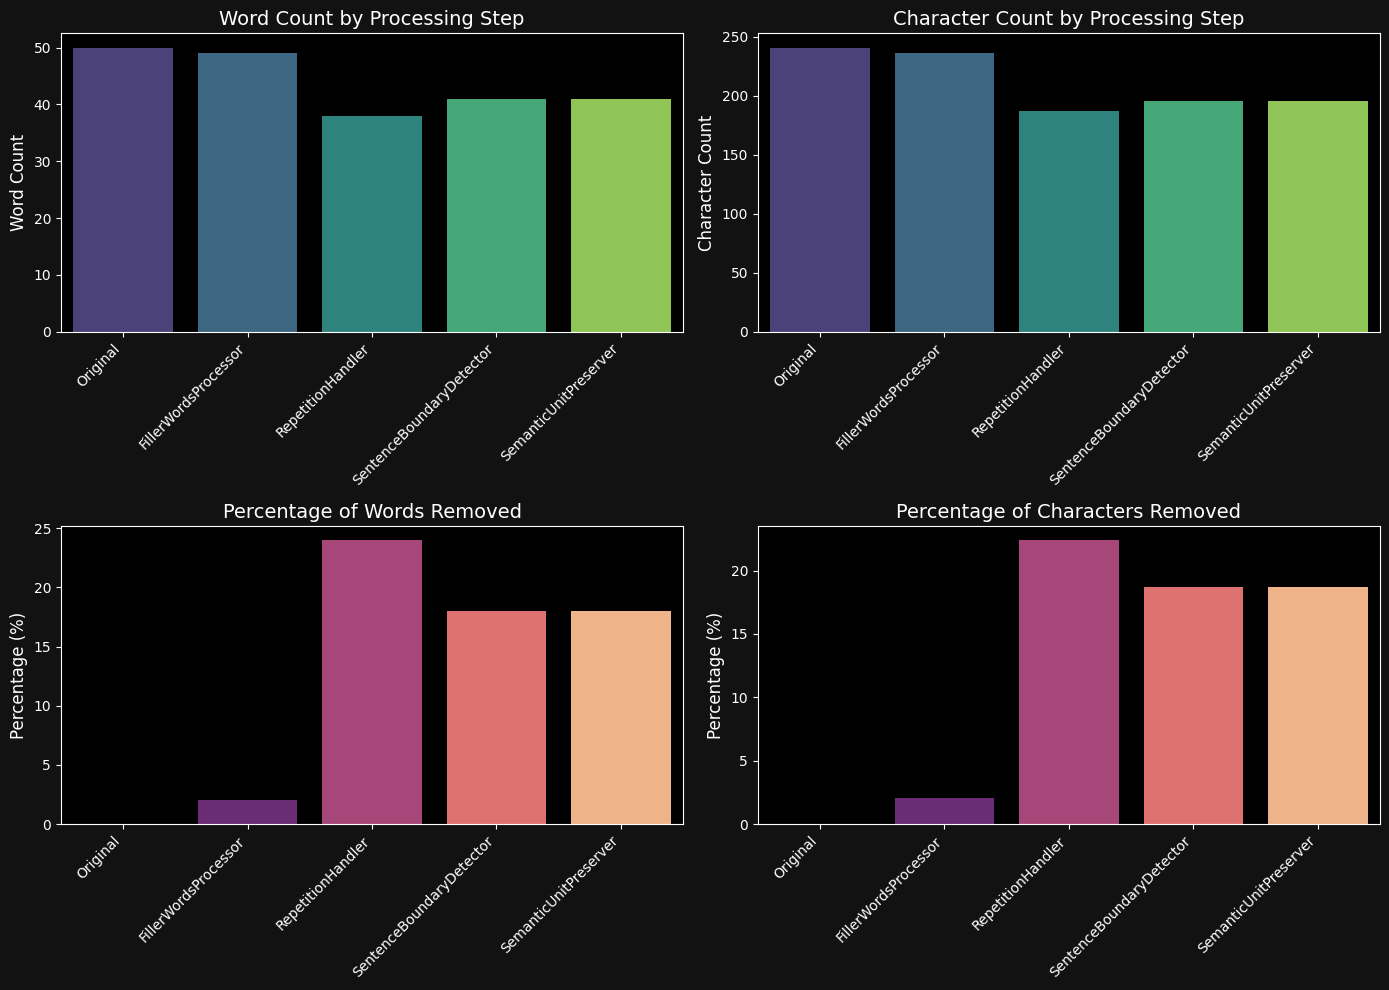

In [3]:
def colorize_diff(text1, text2):
    """
    Create HTML with colorful diff highlighting.
    - Red for removed text
    - Green for added text
    - Gray for unchanged text
    """
    # Split into words for better diffing
    words1 = re.findall(r'\S+|\s+', text1)
    words2 = re.findall(r'\S+|\s+', text2)
    
    # Generate diff
    diff = difflib.ndiff(words1, words2)
    
    # Build HTML with colored spans
    html = []
    for token in diff:
        if token.startswith('- '):
            html.append(f'<span style="background-color: #ffcccc; text-decoration: line-through;">{token[2:]}</span>')
        elif token.startswith('+ '):
            html.append(f'<span style="background-color: #ccffcc;">{token[2:]}</span>')
        elif token.startswith('  '):
            html.append(f'<span style="color: #444444;">{token[2:]}</span>')
            
    return ''.join(html)

def visualize_pipeline_steps(transcript, processors=None):
    """
    Visualize each step of the enhancement pipeline with colorful diffs.
    
    Args:
        transcript: The input transcript text
        processors: List of processor instances or None to use default pipeline
    
    Returns:
        DataFrame with metrics about each transformation
    """
    # Create processors if not provided
    if processors is None:
        processors = [
            FillerWordsProcessor(),
            RepetitionHandler(config={"max_gap": 7}),
            SentenceBoundaryDetector(),
            SemanticUnitPreserver()
        ]
    
    # Initialize data collection
    steps = ['Original']
    texts = [transcript]
    word_counts = [len(transcript.split())]
    char_counts = [len(transcript)]
    
    # Process through each processor
    current_text = transcript
    for processor in processors:
        name = processor.__class__.__name__
        processed_text = processor.process(current_text)
        
        # Store results
        steps.append(name)
        texts.append(processed_text)
        word_counts.append(len(processed_text.split()))
        char_counts.append(len(processed_text))
        
        # Show colorful diff
        print(f"\n### Step: {name} ###")
        diff_html = colorize_diff(current_text, processed_text)
        display(HTML(diff_html))
        
        # Update current text for next processor
        current_text = processed_text
    
    # Create metrics DataFrame
    metrics = pd.DataFrame({
        'Step': steps,
        'Word Count': word_counts,
        'Character Count': char_counts,
        'Words Removed': [word_counts[0] - wc for wc in word_counts],
        'Chars Removed': [char_counts[0] - cc for cc in char_counts],
        'Words Removed %': [(word_counts[0] - wc) / word_counts[0] * 100 for wc in word_counts],
        'Chars Removed %': [(char_counts[0] - cc) / char_counts[0] * 100 for cc in char_counts]
    })
    
    return metrics, texts

def plot_pipeline_metrics(metrics):
    """Plot metrics about the pipeline transformations."""
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), facecolor='#121212')
    
    # Custom dark palette
    dark_palette1 = sns.color_palette("viridis", n_colors=len(metrics))
    dark_palette2 = sns.color_palette("magma", n_colors=len(metrics))
    
    # Word count changes
    ax1 = axes[0, 0]
    sns.barplot(x='Step', y='Word Count', data=metrics, ax=ax1, palette=dark_palette1)
    ax1.set_title('Word Count by Processing Step', color='white', fontsize=14)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', color='white')
    ax1.set_ylabel('Word Count', color='white', fontsize=12)
    ax1.set_xlabel('', color='white')
    ax1.tick_params(colors='white')
    ax1.spines['bottom'].set_color('white')
    ax1.spines['top'].set_color('white')
    ax1.spines['left'].set_color('white')
    ax1.spines['right'].set_color('white')
    
    # Character count changes
    ax2 = axes[0, 1]
    sns.barplot(x='Step', y='Character Count', data=metrics, ax=ax2, palette=dark_palette1)
    ax2.set_title('Character Count by Processing Step', color='white', fontsize=14)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', color='white')
    ax2.set_ylabel('Character Count', color='white', fontsize=12)
    ax2.set_xlabel('', color='white')
    ax2.tick_params(colors='white')
    ax2.spines['bottom'].set_color('white')
    ax2.spines['top'].set_color('white')
    ax2.spines['left'].set_color('white')
    ax2.spines['right'].set_color('white')
    
    # Word removal percentage
    ax3 = axes[1, 0]
    sns.barplot(x='Step', y='Words Removed %', data=metrics, ax=ax3, palette=dark_palette2)
    ax3.set_title('Percentage of Words Removed', color='white', fontsize=14)
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right', color='white')
    ax3.set_ylabel('Percentage (%)', color='white', fontsize=12)
    ax3.set_xlabel('', color='white')
    ax3.tick_params(colors='white')
    ax3.spines['bottom'].set_color('white')
    ax3.spines['top'].set_color('white')
    ax3.spines['left'].set_color('white')
    ax3.spines['right'].set_color('white')
    
    # Character removal percentage
    ax4 = axes[1, 1]
    sns.barplot(x='Step', y='Chars Removed %', data=metrics, ax=ax4, palette=dark_palette2)
    ax4.set_title('Percentage of Characters Removed', color='white', fontsize=14)
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right', color='white')
    ax4.set_ylabel('Percentage (%)', color='white', fontsize=12)
    ax4.set_xlabel('', color='white')
    ax4.tick_params(colors='white')
    ax4.spines['bottom'].set_color('white')
    ax4.spines['top'].set_color('white')
    ax4.spines['left'].set_color('white')
    ax4.spines['right'].set_color('white')
    
    plt.tight_layout()
    return fig

def compare_processor_orderings(transcript, processor_permutations):
    """
    Compare different orderings of processors.
    
    Args:
        transcript: The input transcript text
        processor_permutations: List of lists, where each inner list is a different 
                                ordering of processors
    
    Returns:
        DataFrame with metrics for each permutation
    """
    all_metrics = []
    all_final_texts = []
    
    for i, processors in enumerate(processor_permutations):
        print(f"\n## Permutation {i+1}: {[p.__class__.__name__ for p in processors]} ##")
        metrics, texts = visualize_pipeline_steps(transcript, processors)
        
        # Add permutation identifier
        metrics['Permutation'] = f"Perm {i+1}"
        all_metrics.append(metrics.iloc[-1:])  # Just keep the final row
        all_final_texts.append(texts[-1])
    
    # Combine all final metrics
    combined_metrics = pd.concat(all_metrics, ignore_index=True)
    
    # Compare final texts
    print("\n## Final Text Comparisons ##")
    for i in range(len(all_final_texts)):
        for j in range(i+1, len(all_final_texts)):
            if all_final_texts[i] != all_final_texts[j]:
                print(f"\nDifference between Permutation {i+1} and {j+1}:")
                diff_html = colorize_diff(all_final_texts[i], all_final_texts[j])
                display(HTML(diff_html))
    
    return combined_metrics, all_final_texts

def analyze_repetition_detection(transcript, handler=None):
    """
    Analyze repetition detection on a transcript.
    
    Args:
        transcript: The input transcript text
        handler: RepetitionHandler instance or None to create a new one
    """
    if handler is None:
        handler = RepetitionHandler(config={"max_gap": 7})
    
    tokens = transcript.split()
    
    # Get repetitions using the handler's internal method
    try:
        repetitions = handler._identify_repetitions(tokens)
    except KeyError as e:
        print(f"Error: {e} - This is the issue we're trying to fix!")
        print("Updating the config to include necessary parameters...")
        
        # Add missing parameters and try again
        handler.config.update({
            "min_phrase_length": 3,
            "max_distance": 100
        })
        repetitions = handler._identify_repetitions(tokens)
    
    # Visualize the repetitions
    print(f"Found {len(repetitions)} repeated phrases:")
    
    if not repetitions:
        print("No repetitions found!")
    else:
        # Debug: Print the structure of the first repetition to see what it contains
        if repetitions:
            print("\nRepetition dictionary structure:")
            for key in repetitions[0].keys():
                print(f"- {key}: {type(repetitions[0][key])}")
        
        for i, rep in enumerate(repetitions):
            phrase = ' '.join(rep['phrase'])
            
            # Check what key contains the positions information
            positions_key = None
            for key in rep.keys():
                if key != 'phrase' and isinstance(rep[key], list) and all(isinstance(x, int) for x in rep[key]):
                    positions_key = key
                    break
            
            if positions_key:
                instances = rep[positions_key]
            else:
                # Fallback if we can't find the positions key
                print(f"Warning: Can't find positions for repetition '{phrase}'")
                print(f"Available keys: {list(rep.keys())}")
                instances = []
            
            print(f"\nRepetition {i+1}: '{phrase}'")
            print(f"Found at positions: {instances}")
            
            # Display instances in context with highlighting
            for j, pos in enumerate(instances):
                # Get context before and after
                start = max(0, pos - 3)
                end = min(len(tokens), pos + len(rep['phrase']) + 3)
                
                # Build HTML with highlighting
                html = []
                for k in range(start, end):
                    if k >= pos and k < pos + len(rep['phrase']):
                        html.append(f'<span style="background-color: #ffcc99;">{tokens[k]}</span>')
                    else:
                        html.append(tokens[k])
                
                context_html = ' '.join(html)
                display(HTML(f"<p>Instance {j+1}: ...{context_html}...</p>"))
    
    # Try processing with the handler
    processed = handler.process(transcript)
    print("\nAfter RepetitionHandler processing:")
    diff_html = colorize_diff(transcript, processed)
    display(HTML(diff_html))
    
    return repetitions, processed

# Example usage
print("## Visualizing the default pipeline steps ##")
metrics, texts = visualize_pipeline_steps(complex_transcript)
plot_pipeline_metrics(metrics)

print("\n## Testing different processor permutations ##")
# Define different permutations to try
permutations = [
    # Default order
    [FillerWordsProcessor(), RepetitionHandler(config={"max_gap": 7}), SentenceBoundaryDetector(), SemanticUnitPreserver()],
    # Repetition first
    [RepetitionHandler(config={"max_gap": 7}), FillerWordsProcessor(), SentenceBoundaryDetector(), SemanticUnitPreserver()],
    # Sentence boundaries first
    [SentenceBoundaryDetector(), FillerWordsProcessor(), RepetitionHandler(config={"max_gap": 7}), SemanticUnitPreserver()]
]
combined_metrics, final_texts = compare_processor_orderings(complex_transcript, permutations)

print("\n## Analyzing Repetition Detection ##")
# Create a repetition handler with proper config
repetition_handler = RepetitionHandler(config={"max_gap": 7})
repetition_handler.config.update({
    "strategy": "first_instance",
    "min_phrase_length": 2,  # Lower to catch short phrases
    "max_distance": 100
})
repetitions, processed = analyze_repetition_detection(complex_transcript, repetition_handler)

# Try with the "I think" example
i_think_example = "um I think I think this is a good um good idea"
print("\n## Testing the 'I think' example ##")
think_repetitions, think_processed = analyze_repetition_detection(i_think_example, repetition_handler)

In [5]:
final_texts

["hey everyone what's up |  so I'm here today to tell you that I have not only to give you an update on the only permits blessing |  I'm also here to tell you that in I'm starting another project | ",
 "hey everyone what's up |  so I'm here today to tell you that I have not only to give you an update on the only permits blessing |  I'm also here to tell you that in I'm starting another project | ",
 "hey everyone what's up | so I'm here today to tell you that I have not only to give you an update on the only permits blessing I'm also here to tell you that in I'm starting another project |"]


=== PIPELINE STEP ANALYSIS ===

## Step 1: FillerWordsProcessor ##
Words before: 50, Words after: 49
Words removed: 1 (2.00%)



## Step 2: RepetitionHandler ##
Words before: 49, Words after: 38
Words removed: 11 (22.45%)



## Step 3: SentenceBoundaryDetector ##
Words before: 38, Words after: 41
Words removed: -3 (-7.89%)



## Step 4: SemanticUnitPreserver ##
Words before: 41, Words after: 41
Words removed: 0 (0.00%)



=== PROCESSOR ORDERING ANALYSIS ===

# Ordering 1: FillerWords → Repetition → SentenceBoundaryDetector → SemanticUnitPreserver #
Final word count: 41 (Reduction: 18.00%)



# Ordering 2: Repetition → FillerWords → SentenceBoundaryDetector → SemanticUnitPreserver #
Final word count: 41 (Reduction: 18.00%)



# Ordering 3: FillerWords → SentenceBoundaryDetector → Repetition → SemanticUnitPreserver #
Final word count: 41 (Reduction: 18.00%)



# Ordering 4: SentenceBoundaryDetector → Repetition → FillerWords → SemanticUnitPreserver #
Final word count: 40 (Reduction: 20.00%)



=== REPETITION DETECTION DEBUG ===
Input text with token indices:



Repetition structure:
- phrase: <class 'tuple'>
- groups: <class 'list'>

Identified 2 repeated phrases:
Available keys: ['phrase', 'groups']

Repetition 1: 'I'm also here to tell you that' (length: 7)
Found at positions: []


Available keys: ['phrase', 'groups']

Repetition 2: 'so I'm here today' (length: 4)
Found at positions: []



After RepetitionHandler processing:



=== 'I THINK' EXAMPLE ===
Input text with token indices:



Identified 0 repeated phrases:

After RepetitionHandler processing:


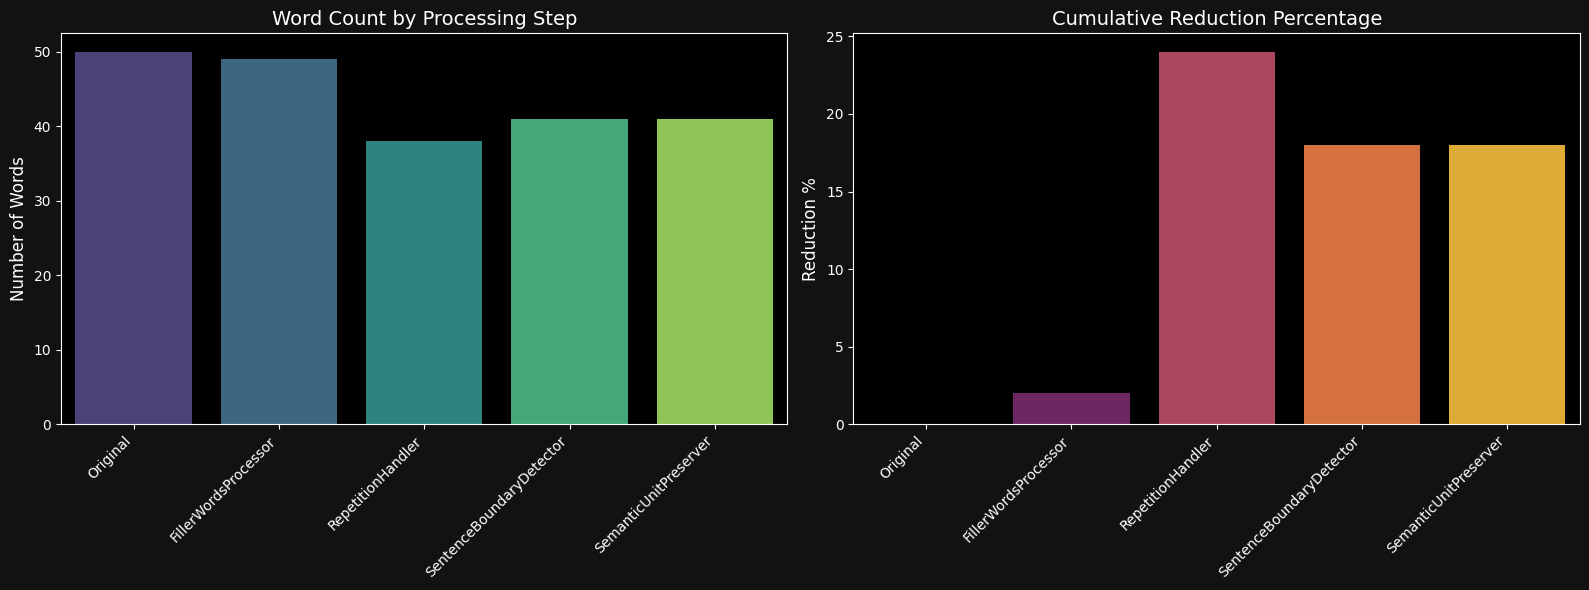

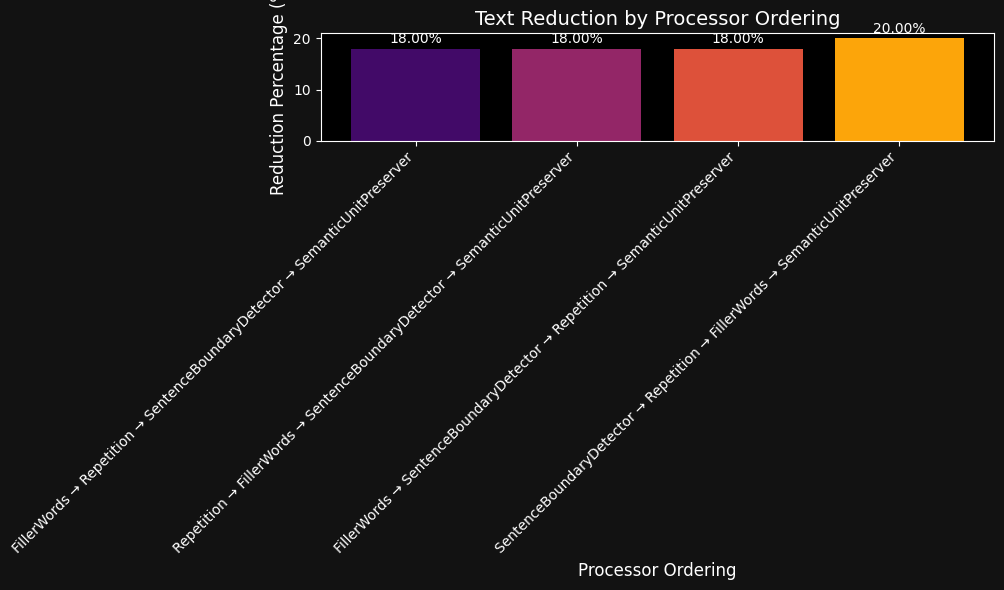

In [4]:
# Function to create HTML highlighting for changes in text
def highlight_diff(before, after):
    """Highlight differences between before and after text."""
    before_words = re.findall(r'\S+|\s+', before)
    after_words = re.findall(r'\S+|\s+', after)
    
    s = difflib.SequenceMatcher(None, before_words, after_words)
    html = []
    
    for tag, i1, i2, j1, j2 in s.get_opcodes():
        if tag == 'equal':
            html.append(''.join(before_words[i1:i2]))
        elif tag == 'delete':
            html.append(f'<span style="background-color: #ffcccc; text-decoration: line-through;">{("".join(before_words[i1:i2]))}</span>')
        elif tag == 'insert':
            html.append(f'<span style="background-color: #ccffcc;">{"".join(after_words[j1:j2])}</span>')
        elif tag == 'replace':
            html.append(f'<span style="background-color: #ffcccc; text-decoration: line-through;">{("".join(before_words[i1:i2]))}</span>')
            html.append(f'<span style="background-color: #ccffcc;">{"".join(after_words[j1:j2])}</span>')
    
    return ''.join(html)

# Function to analyze each step of the pipeline
def analyze_pipeline_steps(transcript, processors=None, verbose=True):
    """Analyze each step of the enhancement pipeline and show changes."""
    
    # Create processors if not provided
    if processors is None:
        processors = [
            FillerWordsProcessor(),
            RepetitionHandler(config={"max_gap": 7}),
            SentenceBoundaryDetector(),
            SemanticUnitPreserver()
        ]
    
    # Initialize tracking
    processing_steps = []
    step_names = ['Original']
    step_texts = [transcript]
    step_word_counts = [len(transcript.split())]
    
    # Process through each processor
    current_text = transcript
    for i, processor in enumerate(processors):
        processor_name = processor.__class__.__name__
        
        # Process the text
        processed_text = processor.process(current_text)
        
        # Store results
        step_names.append(processor_name)
        step_texts.append(processed_text)
        step_word_counts.append(len(processed_text.split()))
        
        # Create visualization data
        step_data = {
            'step': i + 1,
            'processor': processor_name,
            'before': current_text,
            'after': processed_text,
            'words_before': len(current_text.split()),
            'words_after': len(processed_text.split()),
            'words_removed': len(current_text.split()) - len(processed_text.split()),
            'percent_reduction': (len(current_text.split()) - len(processed_text.split())) / len(current_text.split()) * 100 if len(current_text.split()) > 0 else 0,
            'diff_html': highlight_diff(current_text, processed_text)
        }
        
        processing_steps.append(step_data)
        
        # Update for next step
        current_text = processed_text
    
    # Create metrics DataFrame
    metrics = pd.DataFrame({
        'Step': step_names,
        'Word Count': step_word_counts,
        'Words Removed': [step_word_counts[0] - wc for wc in step_word_counts],
        'Reduction %': [(step_word_counts[0] - wc) / step_word_counts[0] * 100 if step_word_counts[0] > 0 else 0 for wc in step_word_counts]
    })
    
    if verbose:
        # Display processing steps with highlighting
        for step in processing_steps:
            print(f"\n## Step {step['step']}: {step['processor']} ##")
            print(f"Words before: {step['words_before']}, Words after: {step['words_after']}")
            print(f"Words removed: {step['words_removed']} ({step['percent_reduction']:.2f}%)")
            display(HTML(f"<div style='background-color: #f5f5f5; padding: 10px; border-radius: 5px;'>{step['diff_html']}</div>"))
    
    return processing_steps, metrics, step_texts

# Function to visualize processor output with charts
def visualize_metrics(metrics):
    """Create visualizations for the metrics."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), facecolor='#121212')
    
    # Create custom color palettes for dark mode
    word_count_palette = sns.color_palette("viridis", n_colors=len(metrics))
    reduction_palette = sns.color_palette("inferno", n_colors=len(metrics))
    
    # Word count chart
    sns.barplot(x='Step', y='Word Count', data=metrics, ax=axes[0], palette=word_count_palette)
    axes[0].set_title('Word Count by Processing Step', color='white', fontsize=14)
    axes[0].set_ylabel('Number of Words', color='white', fontsize=12)
    axes[0].set_xlabel('', color='white')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right', color='white')
    axes[0].tick_params(colors='white')
    axes[0].spines['bottom'].set_color('white')
    axes[0].spines['top'].set_color('white')
    axes[0].spines['left'].set_color('white')
    axes[0].spines['right'].set_color('white')
    
    # Reduction percentage chart
    sns.barplot(x='Step', y='Reduction %', data=metrics, ax=axes[1], palette=reduction_palette)
    axes[1].set_title('Cumulative Reduction Percentage', color='white', fontsize=14)
    axes[1].set_ylabel('Reduction %', color='white', fontsize=12)
    axes[1].set_xlabel('', color='white')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right', color='white')
    axes[1].tick_params(colors='white')
    axes[1].spines['bottom'].set_color('white')
    axes[1].spines['top'].set_color('white')
    axes[1].spines['left'].set_color('white')
    axes[1].spines['right'].set_color('white')
    
    plt.tight_layout()
    return fig

# Function to analyze different processor orderings
def analyze_processor_orderings(transcript):
    """Compare different orderings of processors."""
    # Create processors
    filler = FillerWordsProcessor()
    repetition = RepetitionHandler(config={"max_gap": 7})
    repetition.config.update({"min_phrase_length": 2, "max_distance": 100})  # Fix config
    sentence = SentenceBoundaryDetector()
    semantic = SemanticUnitPreserver()
    
    # Define orderings to test
    orderings = [
        [filler, repetition, sentence, semantic],  # Default
        [repetition, filler, sentence, semantic],  # Repetition first
        [filler, sentence, repetition, semantic],  # Sentence before repetition
        [sentence, repetition, filler, semantic]   # Another variation
    ]
    
    # Process with each ordering
    ordering_results = []
    
    for i, processors in enumerate(orderings):
        ordering_name = ' → '.join([p.__class__.__name__.replace('Processor', '').replace('Handler', '') for p in processors])
        print(f"\n# Ordering {i+1}: {ordering_name} #")
        
        # Process with this ordering
        steps, metrics, texts = analyze_pipeline_steps(transcript, processors, verbose=False)
        
        # Show final result
        print(f"Final word count: {len(texts[-1].split())} (Reduction: {metrics['Reduction %'].iloc[-1]:.2f}%)")
        display(HTML(f"<div style='background-color: #1e1e1e; color: #e0e0e0; padding: 10px; border-radius: 5px;'>{highlight_diff(transcript, texts[-1])}</div>"))
        
        # Store result
        ordering_results.append({
            'ordering_id': i+1,
            'ordering_name': ordering_name,
            'final_text': texts[-1],
            'final_word_count': len(texts[-1].split()),
            'reduction_percentage': metrics['Reduction %'].iloc[-1]
        })
    
    # Compare final results
    results_df = pd.DataFrame(ordering_results)
    
    # Create comparison chart with dark mode
    plt.figure(figsize=(10, 6), facecolor='#121212')
    bars = plt.bar(results_df['ordering_name'], results_df['reduction_percentage'], 
                  color=sns.color_palette("inferno", n_colors=len(results_df)))
    plt.title('Text Reduction by Processor Ordering', color='white', fontsize=14)
    plt.xlabel('Processor Ordering', color='white', fontsize=12)
    plt.ylabel('Reduction Percentage (%)', color='white', fontsize=12)
    plt.xticks(rotation=45, ha='right', color='white')
    plt.yticks(color='white')
    
    # Add dark mode styling to the chart
    ax = plt.gca()
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.tick_params(colors='white')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.2f}%', ha='center', va='bottom', color='white')
    
    plt.tight_layout()
    
    return results_df, ordering_results

# Function to debug repetition detection
def debug_repetition_detection(transcript):
    """Debug the repetition detection functionality."""
    # Create a properly configured repetition handler
    repetition_handler = RepetitionHandler(config={"max_gap": 7})
    repetition_handler.config.update({"min_phrase_length": 2, "max_distance": 100})
    
    # Process transcript
    tokens = transcript.split()
    
    # Display the input text with token indices
    print("Input text with token indices:")
    token_display = []
    for i, token in enumerate(tokens):
        token_display.append(f'<span style="border: 1px solid #ccc; padding: 2px; margin: 2px; display: inline-block;">{i}: {token}</span>')
    
    display(HTML('<div style="line-height: 2.5;">' + ''.join(token_display) + '</div>'))
    
    # Get repetitions using the handler's internal method
    repetitions = repetition_handler._identify_repetitions(tokens)
    
    # Debug: Print the structure of the first repetition
    if repetitions:
        print("\nRepetition structure:")
        for key in repetitions[0].keys():
            print(f"- {key}: {type(repetitions[0][key])}")
    
    # Visualize identified repetitions
    print(f"\nIdentified {len(repetitions)} repeated phrases:")
    
    for i, rep in enumerate(repetitions):
        phrase = ' '.join(rep['phrase'])
        phrase_length = len(rep['phrase'])
        
        # Find the key that contains position information
        positions_key = None
        for key in rep.keys():
            if key != 'phrase' and isinstance(rep[key], list) and all(isinstance(x, int) for x in rep[key] if x is not None):
                positions_key = key
                break
        
        if positions_key:
            instances = rep[positions_key]
        else:
            # Fallback if we can't find the positions key
            print(f"Warning: Can't find positions for repetition '{phrase}'")
            print(f"Available keys: {list(rep.keys())}")
            instances = []
        
        print(f"\nRepetition {i+1}: '{phrase}' (length: {phrase_length})")
        print(f"Found at positions: {instances}")
        
        # Highlight instances in the text
        html = ['<div style="line-height: 2.5;">']
        
        for j, token in enumerate(tokens):
            # Check if this token is part of a repetition instance
            is_repetition = False
            instance_index = None
            
            for k, pos in enumerate(instances):
                if pos is not None and j >= pos and j < pos + phrase_length:
                    is_repetition = True
                    instance_index = k
                    break
            
            if is_repetition:
                color = f"hsl({(instance_index * 60) % 360}, 100%, 85%)"
                html.append(f'<span style="background-color: {color}; border: 1px solid #ccc; padding: 2px; margin: 2px; display: inline-block;">{j}: {token}</span>')
            else:
                html.append(f'<span style="border: 1px solid #ccc; padding: 2px; margin: 2px; display: inline-block;">{j}: {token}</span>')
        
        html.append('</div>')
        display(HTML(''.join(html)))
    
    # Apply the repetition handler and show result
    processed = repetition_handler.process(transcript)
    print("\nAfter RepetitionHandler processing:")
    display(HTML(f"<div style='background-color: #f5f5f5; padding: 10px; border-radius: 5px;'>{highlight_diff(transcript, processed)}</div>"))
    
    return repetitions, processed

# Example with "I think" repetition
i_think_transcript = "um I think I think this is a good um good idea"

# 1. Analyze pipeline steps
print("\n=== PIPELINE STEP ANALYSIS ===")
steps, metrics, texts = analyze_pipeline_steps(complex_transcript)
visualize_metrics(metrics)

# 2. Analyze different processor orderings
print("\n=== PROCESSOR ORDERING ANALYSIS ===")
results_df, ordering_results = analyze_processor_orderings(complex_transcript)

# 3. Debug repetition detection
print("\n=== REPETITION DETECTION DEBUG ===")
repetitions, processed = debug_repetition_detection(complex_transcript)

# 4. Test with "I think" example
print("\n=== 'I THINK' EXAMPLE ===")
think_repetitions, think_processed = debug_repetition_detection(i_think_transcript)

In [2]:
host_dir = "/mnt/d/Work/Asabaal Ventures/Acts of Asabaal/Ask, Seek, Knock/Launch Video"
max_gap = 7
original_path = os.path.join(host_dir, "ASK launch video.txt")
enhanced_path = os.path.join(host_dir, "ASK launch video_enhanced.txt")
with open(original_path, 'r', encoding='utf-8') as f:
    original_text = f.read()
with open(enhanced_path, 'r', encoding='utf-8') as f:
    enhanced_text = f.read()    

In [4]:
visualizer = TranscriptEnhancementVisualizer()
visualizer.load_transcripts(original_path, enhanced_path)
#
# Display enhancement opportunities
#report_df = visualizer.display_enhancement_report()

("hey everyone what's up\nso I'm here today to tell you that I have\nso I'm here today\nnot only to give you an update on the only permits\nblessing um\nI'm also here to tell you that in\nI'm also here to tell you that I'm starting\nanother project\nand this one is part of my initiative called Ask\nSeek Knock\nthis initiative is all about changing\nthe mindset of limitation\nto one of abundance and possibility\nI don't believe that anything is impossible\nthat's what the Bible says\nthat all things are possible for god right\nand so if that's the case\nlet's stop thinking that\nwe have to be limited by the things that we thought\nwe were limited by\nand let's start imagining new things\nand so what happened was\nwhen I was working on the debate\nI got stuck because my project got too big in CapCut\nit blew up to 20 gigabytes and well\nI couldn't load this project\nin my computer's memory anymore\nand I was unable to continue making progress on it\nso what was I gonna do well\nI reached

In [6]:
#visualizer.display_enhancement_chunks()

In [7]:
enhancements = visualizer.find_enhancements(original_text)

In [9]:
enhancement_df = pd.DataFrame(enhancements)

In [10]:
enhancement_df.groupby('category').size().reset_index(name='count')

,category,count
0,false_starts,30
1,filler_words,210
2,repetition,168
3,run_on,1


In [25]:
# Compare original vs enhanced
#visualizer.display_line_comparison(start_line=1, end_line=50)

In [11]:
# Visualize enhancement density
visualizer.create_enhancement_visualization()

AttributeError: 'TranscriptEnhancementVisualizer' object has no attribute 'create_enhancement_visualization'

In [12]:
enhanced_enhancements = visualizer.find_enhancements(enhanced_text)

In [13]:
enhanced_enhancements = pd.DataFrame(enhanced_enhancements)

In [14]:
enhanced_enhancements.groupby('category').size().reset_index(name='count')

,category,count
0,false_starts,56
1,filler_words,210
2,repetition,237
3,run_on,3


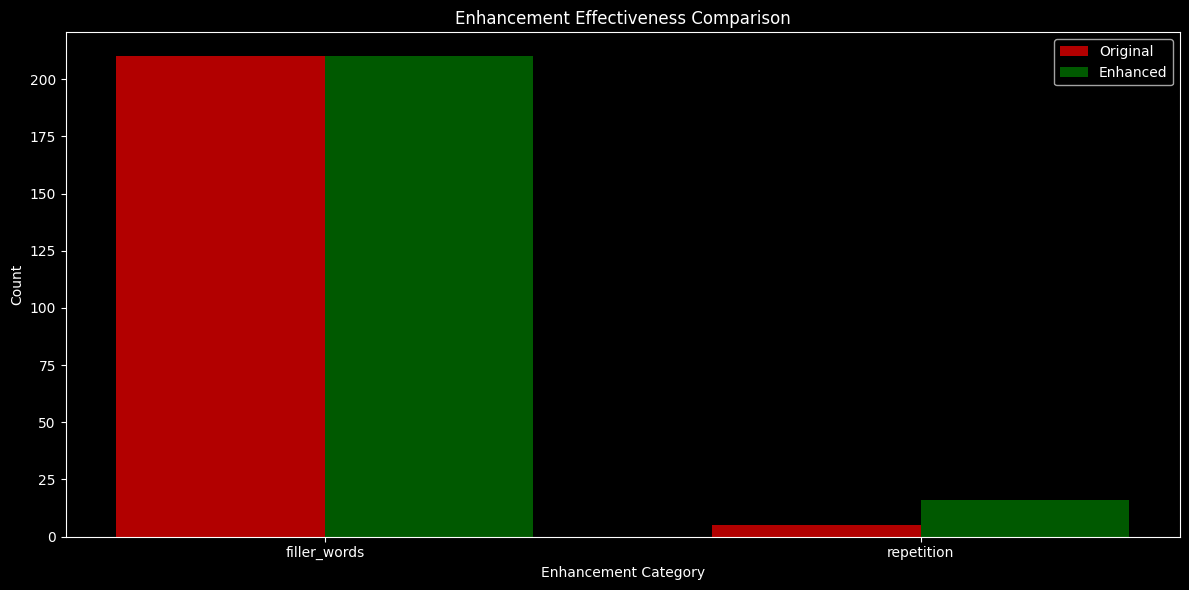

,Category,Original Count,Enhanced Count,Reduction,Reduction %
1,filler_words,210,210,0,0.0
0,repetition,5,16,-11,-220.0


In [57]:
# Analyze effectiveness
effectiveness_df = visualizer.compare_enhancement_effectiveness()
#print(effectiveness_df)
effectiveness_df

In [ ]:
# Analyze patterns
patterns_df = visualizer.analyze_enhancement_patterns()
visualizer.display_enhancement_patterns()